In [1]:
import cv2
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input


In [2]:
#Setting Parameters
num_breeds = 60
im_size = 224
batch_size = 64
encoder = LabelEncoder()


In [3]:
#Reading Data
df_labels = pd.read_csv("labels.csv")
#store training and testing images folder location
train_file = 'train/'
test_file = 'test/'

In [8]:
#get only 60 unique breeds record
breed_dict = list(df_labels['breed'].value_counts().keys()) 
new_list = sorted(breed_dict,reverse=True)[:num_breeds*2+1:2]
#change the dataset to have only those 60 unique breed records
df_labels = df_labels.query('breed in @new_list')
#create new column which will contain image name with the image extension
df_labels['img_file'] = df_labels['id'].apply(lambda x: x + ".jpg")

C:\Users\Farha\AppData\Local\Temp\ipykernel_10228\3117867072.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels['img_file'] = df_labels['id'].apply(lambda x: x + ".jpg")


In [9]:
#create a numpy array of the shape
#(number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = np.zeros((len(df_labels), im_size, im_size, 3), dtype='float32')

#iterate over img_file column of our dataset
for i, img_id in enumerate(df_labels['img_file']):
  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  #(224,224,3) where 3 is the RGB channels layers
  img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
  #scale array into the range of -1 to 1.
  #preprocess the array and expand its dimension on the axis 0 
  img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  #update the train_x variable with new element
  train_x[i] = img_array

#this will be target for model.
#convert breed names into numerical format
train_y = encoder.fit_transform(df_labels["breed"].values)

In [10]:
#split the dataset in the ratio of 80:20. 
#80% for training and 20% for testing purpose
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42)


In [11]:
#Image augmentation using ImageDataGenerator class
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)


In [12]:
#building the model using ResNet50V2 with input shape of our image array
#weights for our network will be from of imagenet dataset
#we will not include the first Dense layer
resnet = ResNet50V2(input_shape=[im_size, im_size, 3], weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_breeds, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=predictions)


In [13]:
epochs = 20
learning_rate = 1e-3

optimizer = RMSprop(learning_rate=learning_rate, rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

model.fit(train_generator, steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
          validation_data=test_generator, validation_steps=x_test.shape[0] // batch_size)


Epoch 1/20
15/15 [==============================] - 114s 7s/step - loss: 1.4810 - accuracy: 0.6212 - val_loss: 0.4972 - val_accuracy: 0.8125
Epoch 2/20
15/15 [==============================] - 95s 6s/step - loss: 0.6076 - accuracy: 0.8153 - val_loss: 0.3825 - val_accuracy: 0.8802
Epoch 3/20
15/15 [==============================] - 96s 6s/step - loss: 0.4808 - accuracy: 0.8437 - val_loss: 0.3177 - val_accuracy: 0.8802
Epoch 4/20
15/15 [==============================] - 98s 6s/step - loss: 0.4042 - accuracy: 0.8699 - val_loss: 0.3487 - val_accuracy: 0.8802
Epoch 5/20
15/15 [==============================] - 70s 4s/step - loss: 0.3689 - accuracy: 0.8835 - val_loss: 0.2838 - val_accuracy: 0.9115
Epoch 6/20
15/15 [==============================] - 42s 3s/step - loss: 0.3428 - accuracy: 0.8771 - val_loss: 0.2321 - val_accuracy: 0.9167
Epoch 7/20
15/15 [==============================] - 44s 3s/step - loss: 0.2901 - accuracy: 0.8982 - val_loss: 0.2654 - val_accuracy: 0.9271
Epoch 8/20
15/15 [=

In [15]:
# Evaluate the model on the test dataset
evaluation_results = model.evaluate(test_generator)

# Print the evaluation results (loss and accuracy)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])


4/4 [==============================] - 8s 2s/step - loss: 0.3053 - accuracy: 0.9216
Test Loss: 0.3052632212638855
Test Accuracy: 0.9215686321258545


Epoch 1/20
15/15 [==============================] - 37s 2s/step - loss: 0.1944 - accuracy: 0.9244 - val_loss: 0.2778 - val_accuracy: 0.9062
Epoch 2/20
15/15 [==============================] - 37s 2s/step - loss: 0.2111 - accuracy: 0.9219 - val_loss: 0.2820 - val_accuracy: 0.9115
Epoch 3/20
15/15 [==============================] - 39s 3s/step - loss: 0.2016 - accuracy: 0.9276 - val_loss: 0.2550 - val_accuracy: 0.9219
Epoch 4/20
15/15 [==============================] - 38s 2s/step - loss: 0.1792 - accuracy: 0.9444 - val_loss: 0.2306 - val_accuracy: 0.9323
Epoch 5/20
15/15 [==============================] - 38s 2s/step - loss: 0.1851 - accuracy: 0.9402 - val_loss: 0.2805 - val_accuracy: 0.9219
Epoch 6/20
15/15 [==============================] - 39s 2s/step - loss: 0.1607 - accuracy: 0.9486 - val_loss: 0.1941 - val_accuracy: 0.9375
Epoch 7/20
15/15 [==============================] - 39s 3s/step - loss: 0.1608 - accuracy: 0.9454 - val_loss: 0.2443 - val_accuracy: 0.9219
Epoch 8/20
15/15 [==

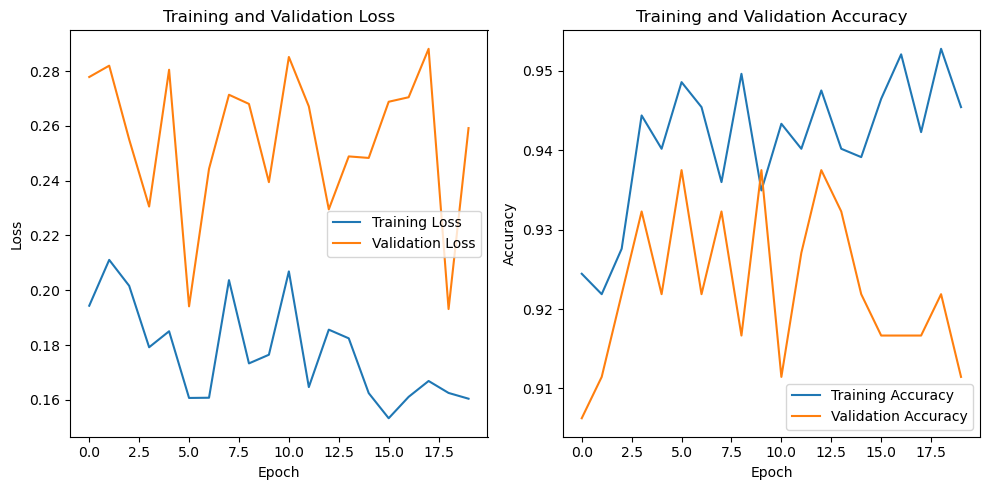

In [21]:
# Train the model
history = model.fit(train_generator, 
                    steps_per_epoch=x_train.shape[0] // batch_size, 
                    epochs=epochs,
                    validation_data=test_generator, 
                    validation_steps=x_test.shape[0] // batch_size)

# Plotting the training and validation loss and accuracy
plt.figure(figsize=(10, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
# Save the trained model
model.save("dog_breed_classification_model")


INFO:tensorflow:Assets written to: dog_breed_classification_model\assets


INFO:tensorflow:Assets written to: dog_breed_classification_model\assets


In [33]:
loaded_model = load_model("dog_breed_classification_model")

In [34]:
# Predict the breed of the dog
pred_img_path = 'yorkshire_terrier.jpg'
pred_img_array = cv2.resize(cv2.imread(pred_img_path, cv2.IMREAD_COLOR), ((im_size, im_size)))
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
pred_val = loaded_model.predict(np.array(pred_img_array, dtype="float32"))

# Map the predicted index to the corresponding breed
pred_breed_index = np.argmax(pred_val)
pred_breed = new_list[pred_breed_index]
print("Predicted Breed for this Dog is:", pred_breed)


1/1 [==============================] - 1s 765ms/step
Predicted Breed for this Dog is: basenji
